In [1]:
import pandas as pd
import numpy as np
import sklearn
from numpy import float16, mean, std
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    KFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(42)  # Set the random seed to 42 for reproducibility

In [3]:
# Load Dataset
file_path = "/Users/Sebastiano/ML_MRI copy.xlsx"
df_2 = pd.read_excel(file_path)

print("N° of patients: {}".format(len(df_2)))
print("N° of columns: {}".format(df_2.shape[1]))
df_2.head()

N° of patients: 47
N° of columns: 932


,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,0,38,1,Mood abnormalities (depressive),0.67586,42.3566,438.3091,35.4223,438.2523,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,0,41,0,Na,0.70729,105.5166,472.6302,37.2214,466.0998,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,job1625735,0,58,2,Na,0.80425,32.0757,444.9024,32.3276,444.4705,...,2.5364,0.022803,19.3760,2.8289,0.025432,2.4842,0.022334,3.1091,0.027951,-22.3438
3,Paziente 3,0,32,0,Na,0.65236,49.4839,407.0018,33.7657,406.9770,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
4,job1625738,0,42,2,Na,0.66906,32.9605,354.9196,31.1643,339.6141,...,2.7589,0.026419,-1.7345,1.9995,0.019147,1.8184,0.017413,2.1486,0.020574,-16.6438


In [4]:
df = df_2[df_2['NP-SLE'] != 2]
df.head()

,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,0,38,1,Mood abnormalities (depressive),0.67586,42.3566,438.3091,35.4223,438.2523,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,0,41,0,Na,0.70729,105.5166,472.6302,37.2214,466.0998,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
3,Paziente 3,0,32,0,Na,0.65236,49.4839,407.0018,33.7657,406.9770,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
5,Paziente 4,0,31,1,Seizure,0.65564,44.8080,424.9121,35.6460,424.8701,...,3.0341,0.028616,-6.5858,2.1641,0.020410,2.2997,0.021689,2.0193,0.019045,12.9849
6,Paziente 5,0,43,0,Na,0.76373,94.5834,548.5729,41.4234,547.8604,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [5]:
# Drop unwanted columns

df = df.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 925 


In [6]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = df.columns.difference(['NP-SLE']) 

# Normalize the selected features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

## NPSLE SLE

In [7]:
np.random.seed(42)

def train_test(data: pd.DataFrame):
    
    """Return train-test subjects"""

    np_patients = df.loc[df['NP-SLE'] == 1]
    nonp_patients = df.loc[df['NP-SLE'] == 0]
    hc_patients = df.loc[df['NP-SLE'] == 2]


    print(f"number of neuro patients: {len(np_patients)}")
    print(f"number of non neuro patients: {len(nonp_patients)}")
    print(f"number of non neuro patients: {len(hc_patients)}")


    number_of_train_nonp = math.floor(0.8 * len(nonp_patients))  # = 
    number_of_train_np = math.floor(0.8 * len(np_patients))
    number_of_train_hc = math.floor(0.8 * len(hc_patients))  # = 
    train_nonp = nonp_patients[:number_of_train_nonp]
    train_np = np_patients[:number_of_train_np]
    train_hc = hc_patients[:number_of_train_hc]

    test_nonp = nonp_patients[number_of_train_nonp:]
    test_np = np_patients[number_of_train_np:]
    test_hc = hc_patients[number_of_train_hc:]

    assert len(train_nonp) + len(test_nonp) == len(nonp_patients)
    assert len(train_np) + len(test_np) == len(np_patients)
    assert len(train_hc) + len(test_hc) == len(hc_patients)

    train = pd.concat([train_np, train_nonp, train_hc])
    test = pd.concat([test_np, test_nonp, test_hc])

    return train, test

In [8]:
train, test = train_test(df)
X_train = train.loc[:,:]
X_test = test.loc[:,:]
y_train = train.pop("NP-SLE")
y_test = test.pop("NP-SLE")

clf = RandomForestClassifier(n_estimators=500)
# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

# Fit the model on the entire training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate and print accuracy
test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", test_accuracy)

from sklearn.metrics import classification_report

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Accuracy:", cv_scores.mean())
report = classification_report(y_test, y_pred, zero_division=0)

# Output the results
print("Classification Report:\n", report)

number of neuro patients: 14
number of non neuro patients: 13
number of non neuro patients: 0
Accuracy on Test Set: 0.8333333333333334
Cross-Validation Scores: [0.8  0.75 0.75 0.5  0.5 ]
Average Cross-Validation Accuracy: 0.6599999999999999
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



In [9]:
ConfusionMatrix = metrics.confusion_matrix(y_test, y_pred)
print(ConfusionMatrix)

[[2 1]
 [0 3]]


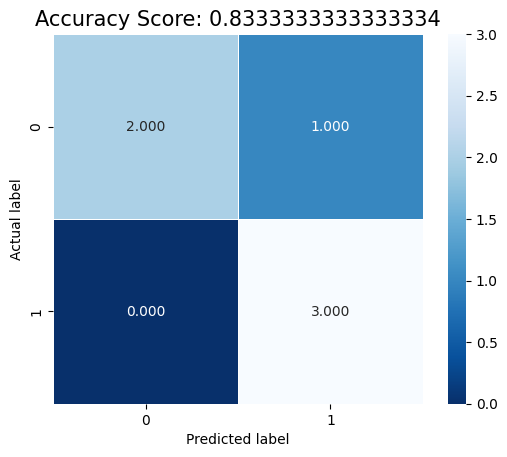

In [10]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

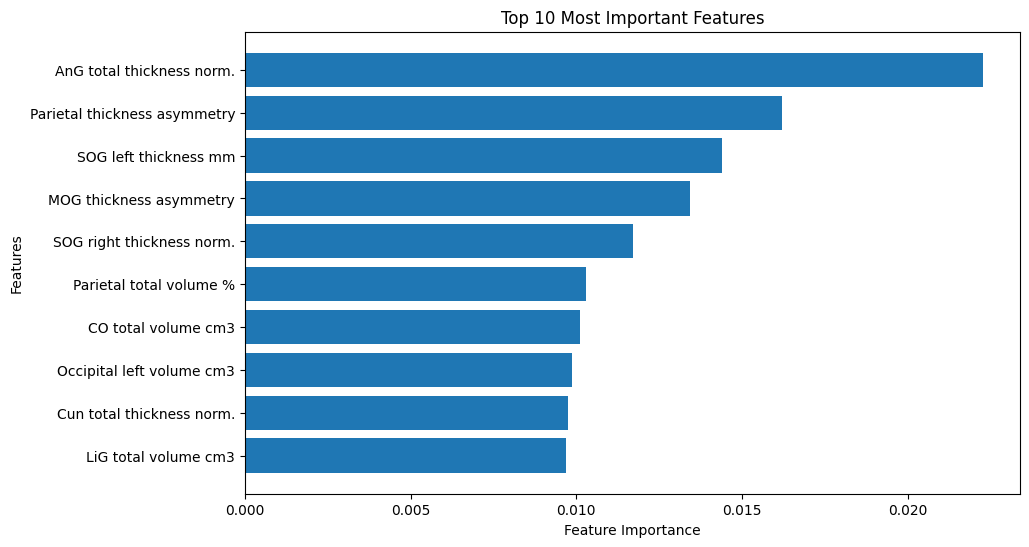

In [11]:
# Get the feature importances
importances = clf.feature_importances_

# Get the indices of the top 10 most important features
top_indices = np.argsort(importances)[-10:]

# Get the names of the top 10 most important features
top_features = df.columns[top_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), importances[top_indices], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features')
plt.show()

## NPSLE - CONTROLS

In [12]:
df = df_2[df_2['NP-SLE'] != 1]
df.head()

,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
1,Paziente 2,0,41,0,Na,0.70729,105.5166,472.6302,37.2214,466.0998,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,job1625735,0,58,2,Na,0.80425,32.0757,444.9024,32.3276,444.4705,...,2.5364,0.022803,19.3760,2.8289,0.025432,2.4842,0.022334,3.1091,0.027951,-22.3438
3,Paziente 3,0,32,0,Na,0.65236,49.4839,407.0018,33.7657,406.9770,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
4,job1625738,0,42,2,Na,0.66906,32.9605,354.9196,31.1643,339.6141,...,2.7589,0.026419,-1.7345,1.9995,0.019147,1.8184,0.017413,2.1486,0.020574,-16.6438
6,Paziente 5,0,43,0,Na,0.76373,94.5834,548.5729,41.4234,547.8604,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [13]:
# Drop unwanted columns

df = df.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 925 


In [14]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = df.columns.difference(['NP-SLE']) 

# Normalize the selected features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [15]:
np.random.seed(42)

def train_test(data: pd.DataFrame):
    
    """Return train-test subjects"""

    np_patients = df.loc[df['NP-SLE'] == 1]
    nonp_patients = df.loc[df['NP-SLE'] == 0]
    hc_patients = df.loc[df['NP-SLE'] == 2]


    print(f"number of neuro patients: {len(np_patients)}")
    print(f"number of non neuro patients: {len(nonp_patients)}")
    print(f"number of non neuro patients: {len(hc_patients)}")


    number_of_train_nonp = math.floor(0.8 * len(nonp_patients))  # = 
    number_of_train_np = math.floor(0.8 * len(np_patients))
    number_of_train_hc = math.floor(0.8 * len(hc_patients))  # = 
    train_nonp = nonp_patients[:number_of_train_nonp]
    train_np = np_patients[:number_of_train_np]
    train_hc = hc_patients[:number_of_train_hc]

    test_nonp = nonp_patients[number_of_train_nonp:]
    test_np = np_patients[number_of_train_np:]
    test_hc = hc_patients[number_of_train_hc:]

    assert len(train_nonp) + len(test_nonp) == len(nonp_patients)
    assert len(train_np) + len(test_np) == len(np_patients)
    assert len(train_hc) + len(test_hc) == len(hc_patients)

    train = pd.concat([train_np, train_nonp, train_hc])
    test = pd.concat([test_np, test_nonp, test_hc])

    return train, test

In [16]:
train, test = train_test(df)
X_train = train.loc[:,:]
X_test = test.loc[:,:]
y_train = train.pop("NP-SLE")
y_test = test.pop("NP-SLE")

clf = RandomForestClassifier(n_estimators=500)
# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

# Fit the model on the entire training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate and print accuracy
test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", test_accuracy)

from sklearn.metrics import classification_report

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Accuracy:", cv_scores.mean())
report = classification_report(y_test, y_pred, zero_division=0)

# Output the results
print("Classification Report:\n", report)

number of neuro patients: 0
number of non neuro patients: 13
number of non neuro patients: 20
Accuracy on Test Set: 1.0
Cross-Validation Scores: [1.  0.8 1.  1.  0.8]
Average Cross-Validation Accuracy: 0.9199999999999999
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [17]:
ConfusionMatrix = metrics.confusion_matrix(y_test, y_pred)
print(ConfusionMatrix)

[[3 0]
 [0 4]]


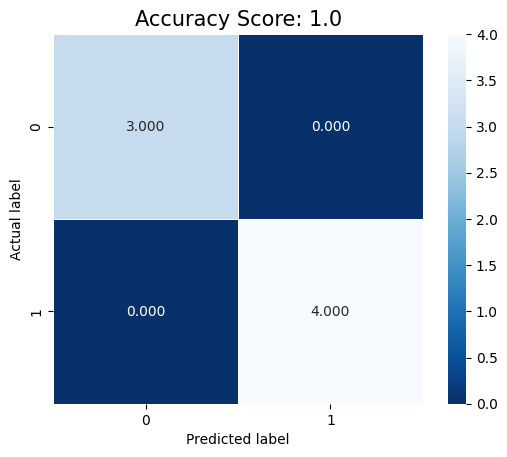

In [18]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

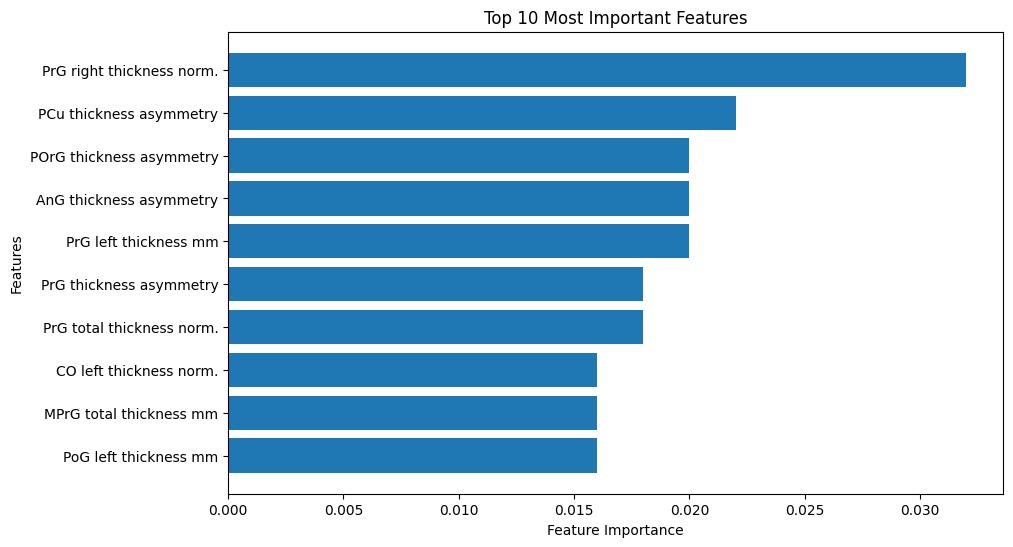

In [19]:
# Get the feature importances
importances = clf.feature_importances_

# Get the indices of the top 10 most important features
top_indices = np.argsort(importances)[-10:]

# Get the names of the top 10 most important features
top_features = df.columns[top_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), importances[top_indices], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features')
plt.show()